In [1]:
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

import numpy as np

from apps import cex_analyse, cex_toy_generator, cex_toy_parameters
from python.analysis import cross_section, Plots, Fitting

from rich import print

cross_section.SetPlotStyle(True, dpi = 100)

def Analyse(analysis_input : cross_section.AnalysisInput, model : cross_section.pyhf.Model, args : cross_section.argparse.Namespace, energy_slices : cross_section.Slices, mean_track_score_bins : np.array):

    region_fit_result = cex_analyse.RegionFit(analysis_input, energy_slices, mean_track_score_bins, model)

    histograms_true_obs, histograms_reco_obs, histograms_reco_obs_err = cex_analyse.BackgroundSubtraction(analysis_input, args.signal_process, energy_slices, region_fit_result) #? make separate background subtraction function?

    # unfolding_args = {"efficiencies" : None, "priors" : None, "regularizers" : None, "ts_stop" : 0.0001, "max_iter" : 10, "ts" : "ks"}
    unfolding_result = cex_analyse.Unfolding(histograms_reco_obs, histograms_reco_obs_err, energy_slices, args.toy_template, args.signal_process, None, None)

    #* integrate into unfolding results
    n_incident_unfolded = cross_section.EnergySlice.NIncident(unfolding_result["init"]["unfolded"], unfolding_result["int"]["unfolded"])
    n_incident_unfolded_err = np.sqrt(unfolding_result["int"]["stat_err"]**2 + np.cumsum(unfolding_result["init"]["stat_err"]**2 + unfolding_result["int"]["stat_err"]**2))

    slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, cross_section.Particle.from_pdgid(211))
    xs = cross_section.EnergySlice.CrossSection(unfolding_result["int_ex"]["unfolded"][1:], unfolding_result["int"]["unfolded"][1:], n_incident_unfolded[1:], slice_dEdX, energy_slices.width, unfolding_result["int_ex"]["stat_err"][1:], unfolding_result["int"]["stat_err"][1:], n_incident_unfolded_err[1:])
    # Plots.plt.close("all")
    return xs


def CreateConfig(PDSP : int = 1, p_init : float = 1000, events : int = 50805, seed : int = None, verbose : bool = False, modified_PDFs : dict[np.array] = None, scale_factors : dict[float] = None, smearing : str = "double_crystal_ball", step : float = 2, beam_profile : str = "gaussian", max_cpus : int = 11):
    return {
    "events" : events,
    "step" : step,
    "p_init" : p_init,
    "beam_profile" : beam_profile,
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_init/{smearing}.json",
        "KE_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int/{smearing}.json",
        "z_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/z_int/{smearing}.json"
    },
    "reco_region_fractions" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : scale_factors,
    "verbose" : verbose,
    "seed" : seed,
    "modified_PDFs" : modified_PDFs,
    "max_cpus" : max_cpus
    }


def SysErr(nominal, modified):
    res = np.nan_to_num(nominal - modified)

    low = res > 0 # the nominal value is higher than the modified, so the change is small
    high = ~low
    
    err_low = abs(np.where(low, res, 0))
    err_high = abs(np.where(high, res, 0))

    return err_low, err_high


env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


# Load data

In [2]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/cex_analysis_2GeV_config.json"))
args.toy_template = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(file = "work/2023/toys/xs_toy_2GeV_cb_2cm_template.hdf5"))
energy_overflow = np.insert(args.energy_slices.pos, 0, args.energy_slices.max_pos + args.energy_slices.width) # xlabels for KE, which has an overflow bin (max energy + energy bin width) 


In [3]:
mean_track_score_bins = np.linspace(0, 1, 21, True)
model = cross_section.RegionFit.CreateModel(args.toy_template, args.energy_slices, None, False, None, False)

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 15, 'channel_1': 15, 'channel_2': 15, 'channel_3': 15}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 0
   auxdata: []


In [26]:
toy_nominal = cross_section.Toy(
    df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(2, 2000, int(1E6),
    seed = 1,
    smearing = "double_crystal_ball",
    step = 2,
    beam_profile = "work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/beam_profile/beam_profile.json",
    max_cpus = 6
    ))))

Simulating |████████████████████████████████████████| 17/17 [100%] in 1:08.7 (0.25/s) 


'BeamSelectionEfficiency' executed in 0.0625s

'GenerateRecoRegions' executed in 1.8951s

'MeanTrackScore' executed in 4.0318s

'main' executed in 78.9267s

# Region fit normalisation systematic

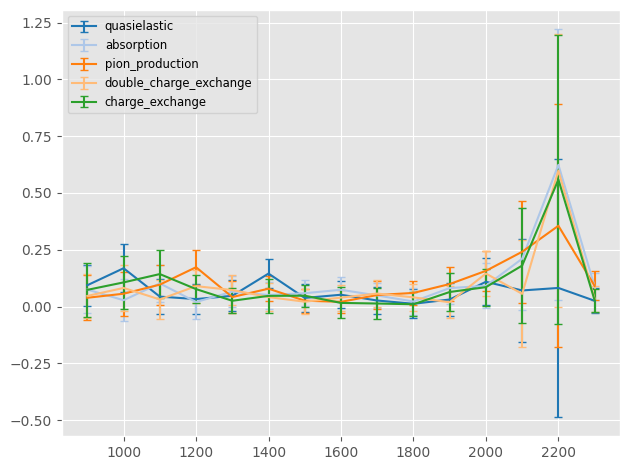

In [16]:
from apps import cex_fit_studies
# read results from region fit
# check which normalisations resulted in the largest fractional error in the background subtracted counts
# remake toys with the given normalisation
# rerun analysis

directory = "test/region_fit_studies_2GeV/normalisation_test_normal/"

s_fe_max, b_fe_max, s_fe_total_max, b_fe_total_max = cex_fit_studies.BackgroundSubtractionSummary(directory, model, "charge_exchange", args.toy_template, "normalisation")

for k in s_fe_max:
    Plots.Plot(energy_overflow, s_fe_max[k][0], yerr = s_fe_max[k][1], label = k, newFigure = False)


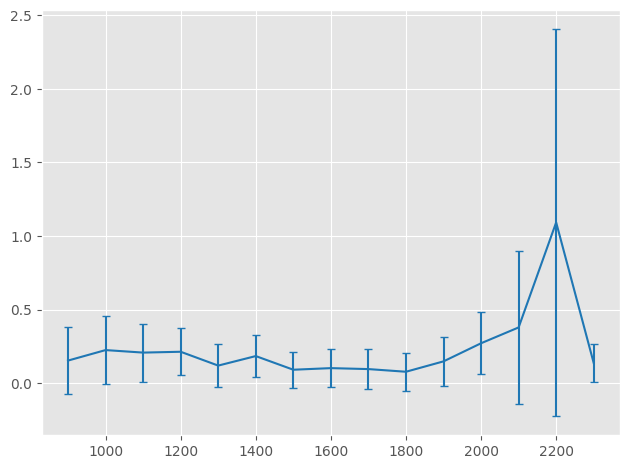

In [25]:
s_fe_sum = cross_section.quadsum([s_fe_max[i][0] for i in s_fe_max], 0)

s_fe_sum_err = cross_section.quadsum([s_fe_max[i][1] for i in s_fe_max], 0)

Plots.Plot(energy_overflow, s_fe_sum, yerr = s_fe_sum_err)

In [27]:
analysis_input_nominal = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_nominal)

# Detector parameterisation systematic

In [7]:
def CreateNewAnalysisInput(toy : cross_section.Toy, new_smearing : cross_section.pd.DataFrame):
    new_smeared = cex_toy_generator.ApplySmearing(toy.df, new_smearing)
    analysis_input = cross_section.AnalysisInput.CreateAnalysisInputToy(toy)
    analysis_input.KE_init_reco = new_smeared.KE_init_smeared
    analysis_input.track_length_reco = new_smeared.z_int_smeared
    analysis_input.KE_int_reco = new_smeared.KE_int_smeared
    return analysis_input


model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697499.29650286])


using KE_int,ex from region fit

signal: charge_exchange

using default options for unfolding

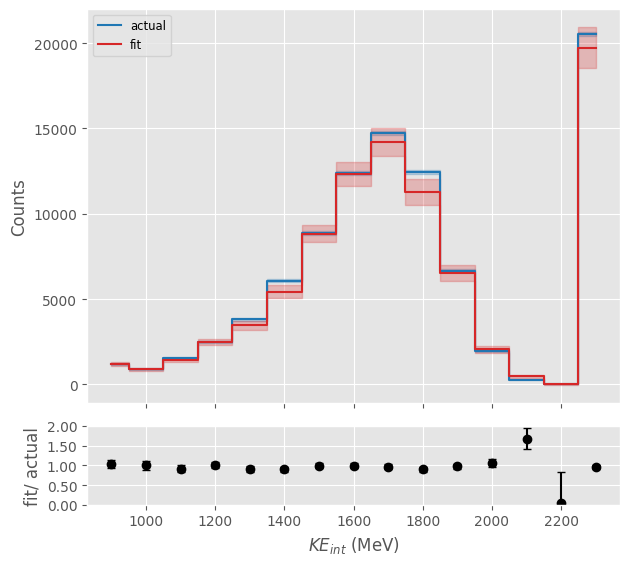

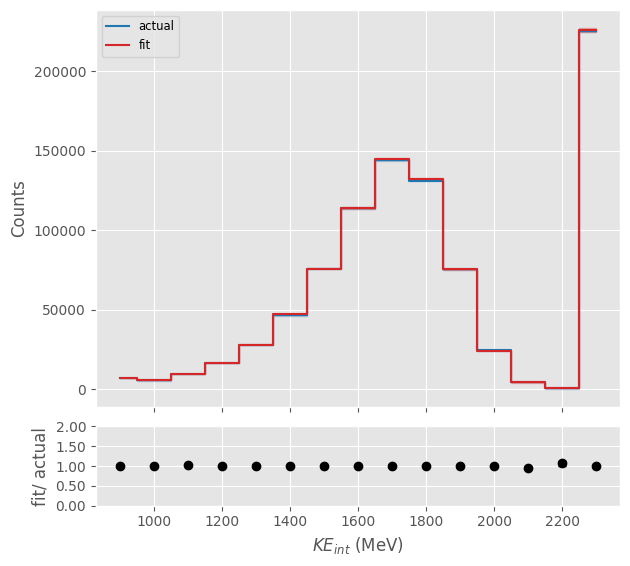

In [28]:
xs_nominal = Analyse(analysis_input_nominal, model, args, args.energy_slices, None)

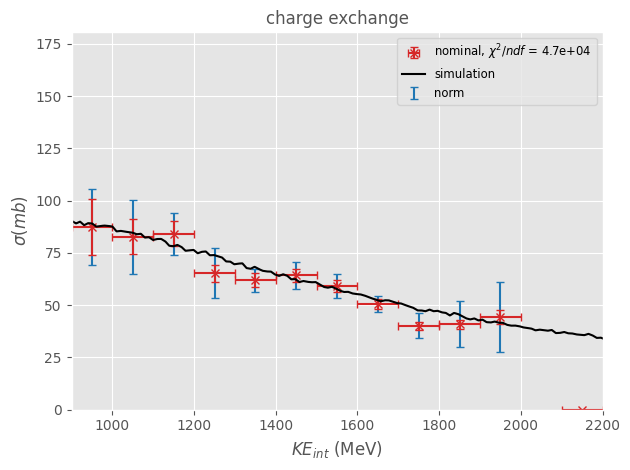

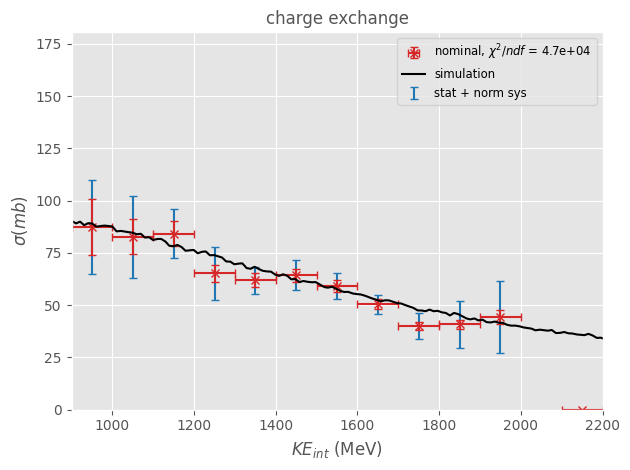

In [45]:
# print(xs_nominal)
# print(s_fe_sum)

norm_err = abs(s_fe_sum[:-1] * xs_nominal[0])
cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k")
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = norm_err, linestyle = "", marker = "", label = "norm", newFigure = False, zorder = 1)

cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C6"}, xs_sim_color = "k")
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = cross_section.quadsum([norm_err, xs_nominal[1]], 0), linestyle = "", marker = "", label = "stat + norm sys", newFigure = False, zorder = 1)

# cross_section.PlotXSComparison({"nominal" : xs_nominal}, args.energy_slices, "charge_exchange", {"nominal" : "C0"}, xs_sim_color = "k")

In [9]:
smearing_params = {
    "KE_init" : cross_section.LoadConfiguration("/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_init/double_crystal_ball.json"),
    "KE_int" : cross_section.LoadConfiguration("/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int/double_crystal_ball.json"),
    "z_int" : cross_section.LoadConfiguration("/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/z_int/double_crystal_ball.json")
    }

p_high = {}
p_low = {}
for i, j in smearing_params.items():
    p_high[i] = {k : j["values"][k] + j["errors"][k] for k in j["values"]}
    p_low[i] = {k : j["values"][k] - j["errors"][k] for k in j["values"]}

smearing = cross_section.pd.DataFrame({f"{k}_smearing" : cross_section.Fitting.RejectionSampling(len(toy_nominal.df), min(v["range"]), max(v["range"]), getattr(cross_section.Fitting, v["function"]), v["values"], rng = np.random.default_rng(1)) for k, v in smearing_params.items()})
analysis_input_nominal = CreateNewAnalysisInput(toy_nominal, smearing)


model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697506.36641138])


using KE_int,ex from region fit

signal: charge_exchange

using default options for unfolding

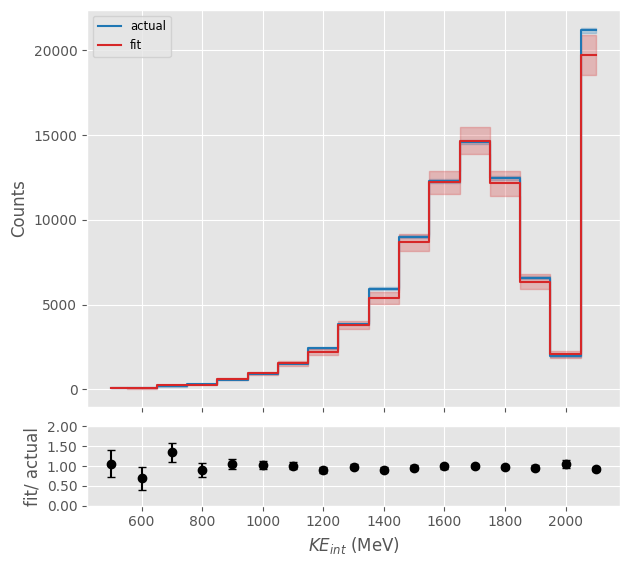

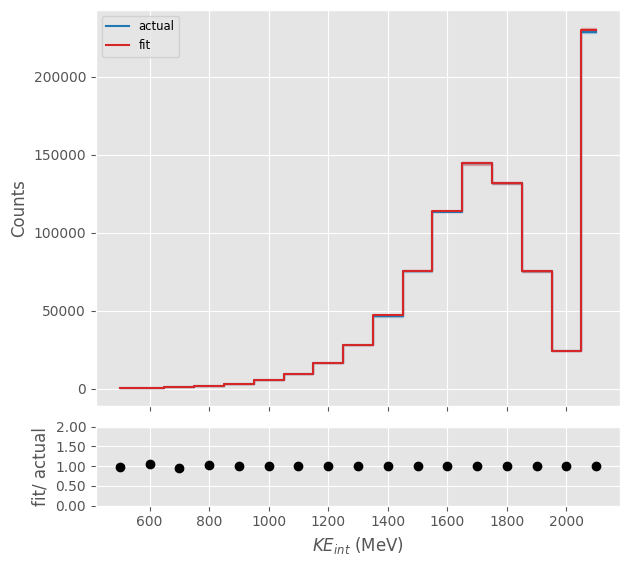

In [35]:
xs_nominal = Analyse(analysis_input_nominal, model, args, args.energy_slices, None)

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697510.71838703])


using KE_int,ex from region fit

signal: charge_exchange

using default options for unfolding

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-6697511.60158785])


using KE_int,ex from region fit

signal: charge_exchange

using default options for unfolding

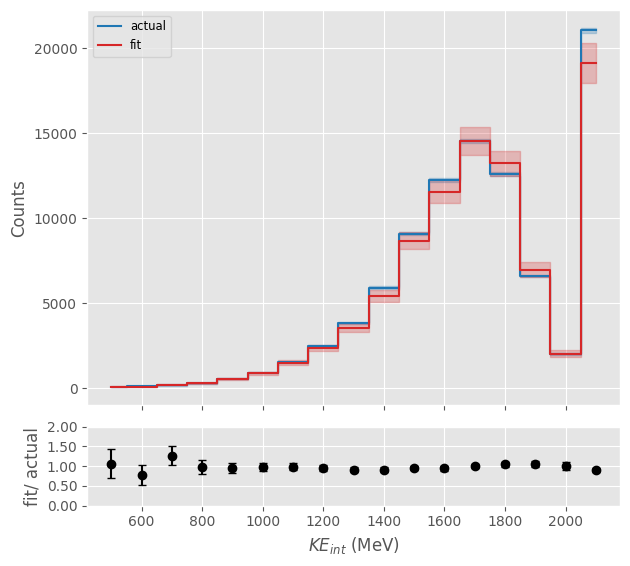

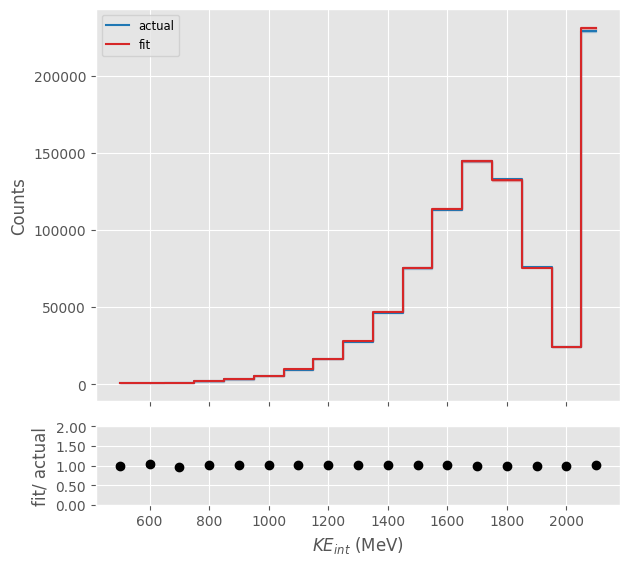

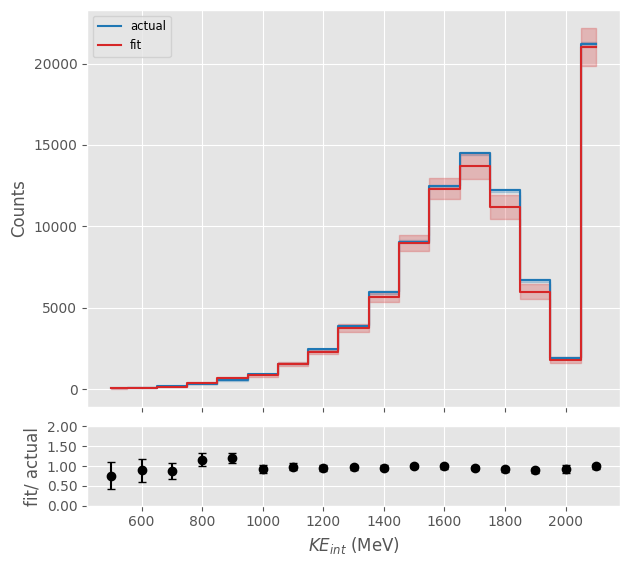

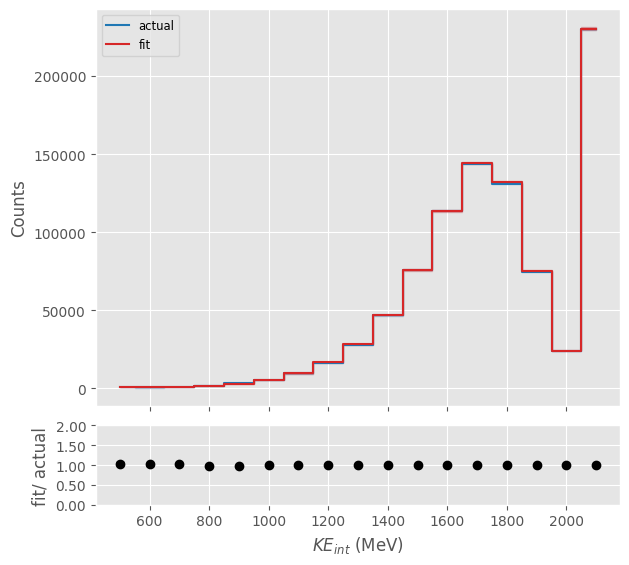

In [36]:
smearing_high = cross_section.pd.DataFrame({f"{k}_smearing" : cross_section.Fitting.RejectionSampling(len(toy_nominal.df), min(v["range"]), max(v["range"]), getattr(cross_section.Fitting, v["function"]), p_high[k], rng = np.random.default_rng(1)) for k, v in smearing_params.items()})
smearing_low = cross_section.pd.DataFrame({f"{k}_smearing" : cross_section.Fitting.RejectionSampling(len(toy_nominal.df), min(v["range"]), max(v["range"]), getattr(cross_section.Fitting, v["function"]), p_low[k], rng = np.random.default_rng(1)) for k, v in smearing_params.items()})
analysis_input_high = CreateNewAnalysisInput(toy_nominal, smearing_high)
analysis_input_low = CreateNewAnalysisInput(toy_nominal, smearing_low)

xs_high = Analyse(analysis_input_high, model, args, args.energy_slices, None)
xs_low = Analyse(analysis_input_low, model, args, args.energy_slices, None)

In [37]:
book = Plots.PlotBook("detector_sys_5E6.pdf", False)

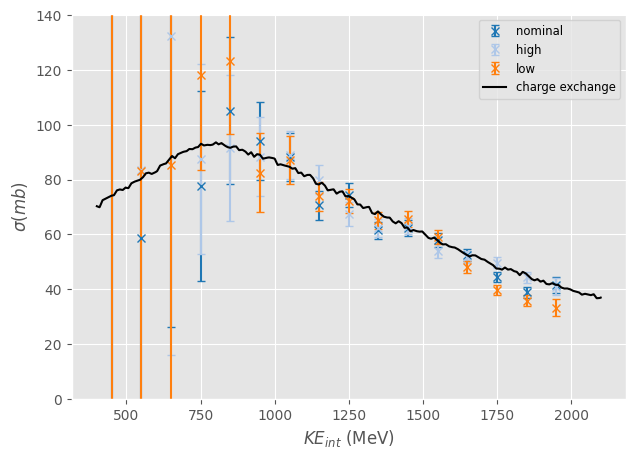

In [38]:
geant_xs = cross_section.GeantCrossSections(energy_range = [args.energy_slices.min_pos - args.energy_slices.width, args.energy_slices.max_pos + args.energy_slices.width])

Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "nominal")
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_high[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "high", newFigure = False)
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_low[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "low", newFigure = False)
geant_xs.Plot("charge_exchange", color = "k")

Plots.plt.ylim(0, 1.5 * max(getattr(geant_xs, "charge_exchange")))

book.Save()

(
    array([8.16385684e+00, 3.00868747e+00, 4.71022315e+00, 4.58608220e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.13904102e+00,
       0.00000000e+00, 1.24420942e+00, 1.15050134e+01, 0.00000000e+00,
       0.00000000e+00, 5.70225101e+01, 0.00000000e+00, 1.35180984e+03]),
    array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.86802923,
        3.09233431,  3.63858351,  0.        ,  3.35656023,  0.        ,
        0.        , 18.21766167, 40.47410979,  0.        , 24.53358491,
        0.        ])
)

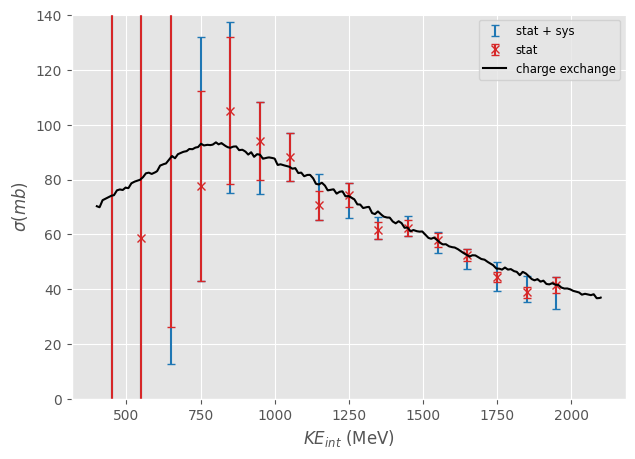

In [39]:
def quadsum(*arg):
    return np.sqrt(sum([a**2 for a in arg]))

err_high_var = SysErr(xs_nominal[0], xs_high[0])
err_low_var = SysErr(xs_nominal[0], xs_low[0])

sys_err_low = quadsum(err_low_var[0], err_high_var[0])
sys_err_high = quadsum(err_low_var[1], err_high_var[1])

print(err_low_var)

total_err_low = quadsum(xs_nominal[1], sys_err_low)
total_err_high = quadsum(xs_nominal[1], sys_err_high)

Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = (total_err_low, total_err_high), linestyle = "", marker = "", label = "stat + sys", newFigure = False)
# Plots.Plot(energy_slices.pos - energy_slices.width/2, xs_nominal[0], yerr = (sys_err_low, sys_err_high), linestyle = "", marker = "", label = "sys", newFigure = False)
Plots.Plot(args.energy_slices.pos - args.energy_slices.width/2, xs_nominal[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "stat", color = "C6", newFigure = False)
geant_xs.Plot("charge_exchange", "k")
Plots.plt.ylim(0, 1.5 * max(getattr(geant_xs, "charge_exchange")))

book.Save()
book.close()